In [ ]:
!mkdir data

In [ ]:
!cd data

In [ ]:
!unzip -q '/content/data/data.zip' -d '/content/data/'

**1. Muat Dataset dari File**

In [ ]:
import pandas as pd

# Load only a subset of the data
train_data = pd.read_csv('/content/data/emnist-bymerge-train.csv', nrows=1000)  # Ambil 10.000 baris
test_data = pd.read_csv('/content/data/emnist-bymerge-test.csv', nrows=500)  # Ambil 5.000 baris

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (1000, 785)
Test data shape: (500, 785)


**2. Pisahkan Fitur dan Label:**

In [ ]:
# Split features and labels
X_train = train_data.iloc[:, 1:].values  # Data pixel
y_train = train_data.iloc[:, 0].values   # Label

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train: (1000, 784)
Shape of y_train: (1000,)


**3. Reshape Data untuk Pemrosesan Gambar**

In [ ]:
# Reshape menjadi 28x28
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)
print("Reshaped X_train:", X_train.shape)


Reshaped X_train: (1000, 28, 28)


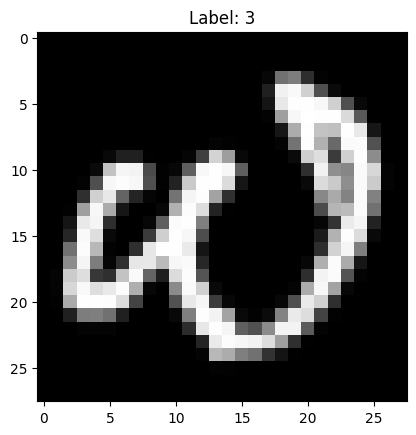

In [ ]:
import matplotlib.pyplot as plt

# Menampilkan gambar pertama
plt.imshow(X_train[100], cmap='gray')  # cmap='gray' untuk citra grayscale
plt.title(f'Label: {y_train[100]}')  # Menampilkan label gambar
plt.show()


**4. Ekstraksi Fitur HOG**

In [ ]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

def extract_hog_features(images):
    hog_features = []
    for image in images:
        hog_feat = hog(image,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       block_norm='L2-Hys')
        hog_features.append(hog_feat)
    return hog_features

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

# Standarisasi fitur HOG
scaler = StandardScaler()
X_train_hog = scaler.fit_transform(X_train_hog)
X_test_hog = scaler.transform(X_test_hog)

print("Shape of HOG features (X_train):", len(X_train_hog[0]))


Shape of HOG features (X_train): 144


**5. Membangun dan Melatih Model SVM**

In [ ]:
from sklearn.svm import SVC

# Inisialisasi model SVM
svm_model = SVC(kernel='linear', C=1.0)

# Latih model SVM
svm_model.fit(X_train_hog, y_train)

# Prediksi pada test set
y_pred = svm_model.predict(X_test_hog)


**6. Evaluasi Model**

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score
import numpy as np
from skimage.feature import hog
from skimage import exposure

# Fungsi untuk mengekstrak fitur HOG
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Ekstraksi HOG
        features = hog(img.reshape(28, 28), pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

# Ekstrak fitur HOG dari X_train
X_train_hog = extract_hog_features(X_train)

# Inisialisasi Leave-One-Out
loo = LeaveOneOut()

# Menyimpan hasil
y_true = []
y_pred = []

# Loop untuk setiap split LOOCV
for train_index, test_index in loo.split(X_train_hog):
    X_train_loo, X_test_loo = X_train_hog[train_index], X_train_hog[test_index]
    y_train_loo, y_test_loo = y_train[train_index], y_train[test_index]

    # Melatih model SVM
    model = SVC(kernel='linear')  # Anda bisa mengganti kernel jika perlu
    model.fit(X_train_loo, y_train_loo)

    # Melakukan prediksi
    y_pred_loo = model.predict(X_test_loo)

    # Menyimpan hasil
    y_true.append(y_test_loo[0])
    y_pred.append(y_pred_loo[0])

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Menampilkan hasil
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Precision:", precision)
print("F1 Score:", f1)



Accuracy: 0.696
Confusion Matrix:
 [[33  0  0 ...  0  0  0]
 [ 0 36  0 ...  0  0  1]
 [ 0  0 50 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 15  0]
 [ 0  1  0 ...  0  0 17]]
Precision: 0.6869566267664282
F1 Score: 0.684181524375508


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


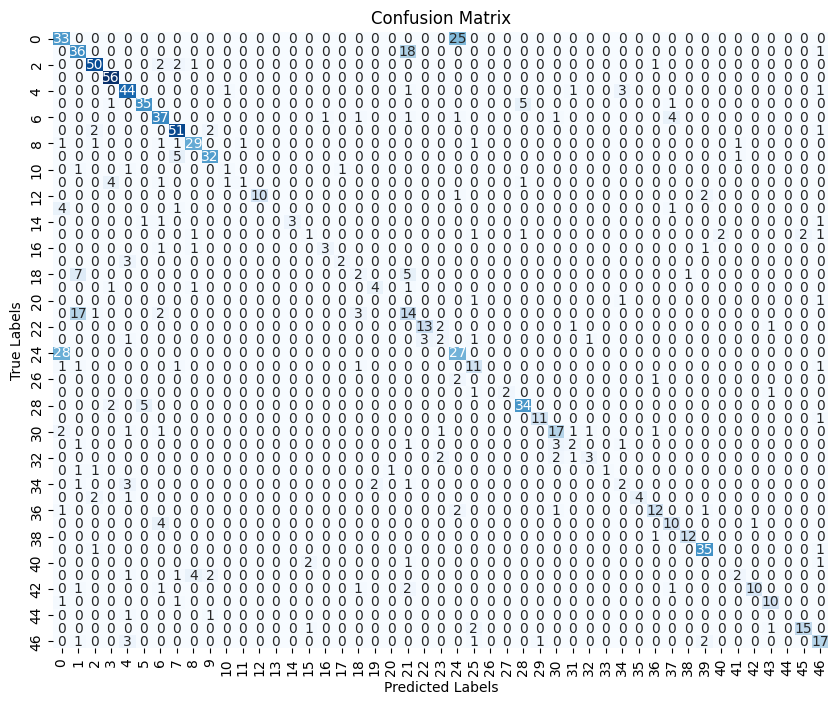

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Hitung confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Membuat plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
